## Equivalent Circuit Bayesian Inference

In this notebook, we introduce the Monte Carlo sampling methods for an example Thevenin model. This notebook includes importing experimental data for a Tesla 4680 NCA/Gr cell, and identifying the resistance elements of a two-RC Thevenin model. First, we import PyBOP and the required packages,

In [ ]:
%pip install --upgrade pip ipywidgets -q
%pip install pybop -q
%pip install pandas -q

import sys

import numpy as np
import pandas as pd
import pybamm

import pybop

pybop.plot.PlotlyManager().pio.renderers.default = "notebook_connected"
parallel = True if sys.platform != "win32" else False

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Next, we will import and process the experimental data. The data for this notebook was obtained from the supplemental data provided in:  

[1] M. Ank et al., ‘Lithium-Ion Cells in Automotive Applications: Tesla 4680 Cylindrical Cell Teardown and Characterization’, doi: 10.1149/1945-7111/ad14d0.

A portion of this data is retained in the PyBOP repository for use in parameterisation and optimisation examples. However, users' are pointed to the official location https://mediatum.ub.tum.de/1725661 for more information. First, we import the three-electrode pOCV dataset,


In [ ]:
ocv_df = pd.read_csv(
    "../../data/Tesla_4680/T-cell_pOCV_data.txt",
    sep="\t",
    decimal=",",
)

Next, let's plot the terminal voltage to visualise the protocol. 

<Axes: xlabel='time/h'>

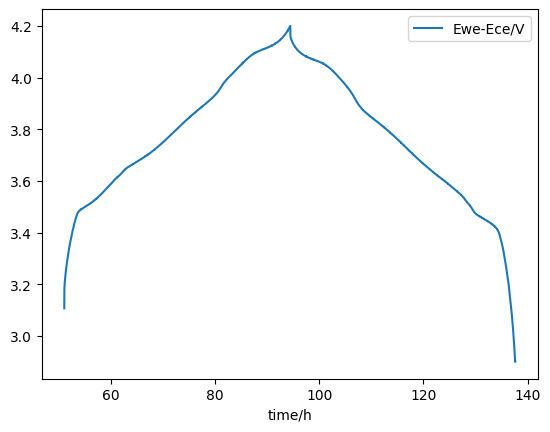

In [ ]:
ocv_df.plot(y="Ewe-Ece/V", x="time/h", kind="line")

As we are aiming to identify the resistance elements in an equivalent circuit model, we will construct an OCV function from the discharge portion of the experimental data. This is done by filtering the dataframe and appending an additional point to ensure the OCV function has data across the operating region (i.e. up to 4.2V).

In [ ]:
sto_measured = (
    1
    - ocv_df.loc[(ocv_df["I/mA"] <= 0.0), "Capacity/mA.h"]
    / ocv_df.loc[(ocv_df["I/mA"] <= 0.0), "Capacity/mA.h"].iloc[-1]
)
V_measured = ocv_df.loc[(ocv_df["I/mA"] <= 0.0), "Ewe-Ece/V"]
V_measured.iloc[0] = 4.2  # Extend for improved interpolation (a bit of a fudge)

In [ ]:
def ocv(sto):
    name = "OCV"
    x = np.flip(sto_measured.to_numpy())
    y = np.flip(V_measured.to_numpy())
    return pybamm.Interpolant(x, y, sto, name)

Next, let's construct the parameter set and update it with the known information and placeholder values for this cell.

In [ ]:
parameter_set = pybamm.equivalent_circuit.Thevenin().default_parameter_values
parameter_set.update(
    {
        "Cell capacity [A.h]": 22.651,  # 083/828 - C/20
        "Nominal cell capacity [A.h]": 22.651,
        "Current function [A]": 22.651,
        "Initial SoC": 1.0,
        "Upper voltage cut-off [V]": 4.25,  # Extended to avoid hitting event
        "Lower voltage cut-off [V]": 2.5,
        "Open-circuit voltage [V]": ocv,
        "R2 [Ohm]": 1e-4,  # placeholder
        "C2 [F]": 4e5,  # placeholder
        "Element-2 initial overpotential [V]": 0,
    },
    check_already_exists=False,
)

## Import Cycling Data
Now we import the corresponding constant current tests for this cell and construct a dataset from a subset of this time-series. This is done to reduce the computational time for inference, but also to improve the robustness of the inference task.

<Axes: xlabel='time/s'>

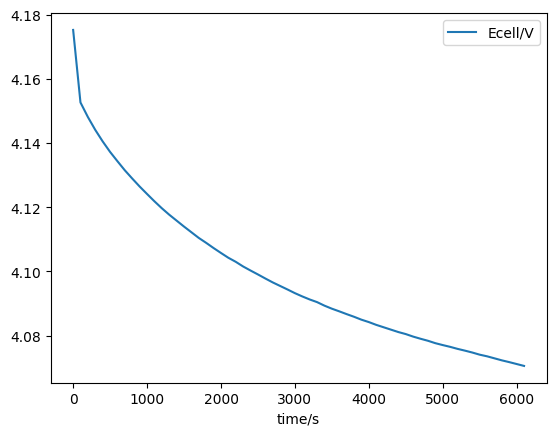

In [ ]:
cycling_df = pd.read_csv(
    "../../data/Tesla_4680/601-828_Capacity_03_MB_CB1_subset.txt",
    sep="\t",
)
filter_cycling = cycling_df.loc[54811:61000].copy()  # Full cycle is [54811:127689]
filter_cycling["time/s"] = filter_cycling["time/s"] - filter_cycling["time/s"].iloc[0]

# Take every 100th point
filtered_cycling_df = filter_cycling.iloc[
    [i for i in range(len(filter_cycling)) if not i % 100 != 0]
]
filtered_cycling_df.plot(x="time/s", y="Ecell/V", kind="line")

### Defining the parameters for inference

In [ ]:
parameters = [
    pybop.Parameter(
        "R0 [Ohm]",
        prior=pybop.Gaussian(3e-3, 1e-3),
        bounds=[1e-5, 1e-2],
    ),
    pybop.Parameter(
        "R1 [Ohm]",
        prior=pybop.Gaussian(5e-3, 1e-3),
        bounds=[1e-5, 1e-2],
    ),
    pybop.Parameter(
        "R2 [Ohm]",
        prior=pybop.Gaussian(1e-4, 5e-5),
        bounds=[1e-5, 1e-2],
    ),
]

### Form the dataset using the filtered data
In this parameter inference task, we use the filtered time-series data to reduce the computation time. This choice can be validated by comparing the inference results to the full time-series inference, which isn't covered in this example.

In [ ]:
dataset_hundred = pybop.Dataset(
    {
        "Time [s]": filtered_cycling_df["time/s"].to_numpy(),
        "Current function [A]": -filtered_cycling_df["I/mA"].to_numpy()
        / 1000,  # Convert mA to A
        "Voltage [V]": filtered_cycling_df["Ecell/V"].to_numpy(),
    }
)

### Construct the problem builder
We now construct a two-pair RC model and build the model with an initial SOC based on the first voltage point in the experimental data. 
We use PyBaMM's `NegativeGaussianLogLikelihood` function in the builder.

In [ ]:
model = pybamm.equivalent_circuit.Thevenin(options={"number of rc elements": 2})
parameter_set.set_initial_state(f"{dataset_hundred['Voltage [V]'][0]} V")

builder = (
    pybop.builders.Pybamm()
    .set_dataset(dataset_hundred)
    .set_simulation(model, parameter_values=parameter_set)
    .add_cost(
        pybop.costs.pybamm.NegativeGaussianLogLikelihood("Voltage [V]", "Voltage [V]")
    )
)
for param in parameters:
    builder.add_parameter(param)
problem = builder.build()

### Let's find the Maximum a Posteriori values
Below we identify the parameters using the Maximum a Posterior estimate and the Covariance Matrix Adaptation Evolution Strategy (CMAES). We will use this estimate later in the Bayesian inference task as a starting position for the chains.

In [ ]:
options = pybop.PintsOptions(
    sigma=[1e-4, 1e-4, 1e-4, 1e-4],
    max_unchanged_iterations=40,
    max_iterations=200,
)
optim = pybop.CMAES(problem, options=options)
results = optim.run()

Next, we can plot the MAP results:

In [ ]:
print("Optimisation results:", results.x)
pybop.plot.convergence(optim)
pybop.plot.parameters(optim);

Optimisation results: [2.31557556e-03 4.31659712e-03 9.87780179e-05 9.05184545e-03]


### Monte Carlo Sampling
Below we construct the Monte Carlo sampler, specifically the Hamiltionian sampler, which samples from the posterior using Hamiltonion dynamics with gradient information. To minimise the time to execute this notebook, we greatly limit the number of samples; however, this should be increased for actual inference tasks. We initialise the chains from the Maximum a Posteriori point-estimate obtained from the CMAES optimisation above, as this should be close to the mode of the posterior.

In [ ]:
options = pybop.PintsSamplerOptions(
    n_chains=3,
    x0=results.x,  # Initialise at the MAP estimate
    max_iterations=500,  # Increase for accurate posteriors
    warm_up_iterations=350,
    verbose=True,
)

sampler = pybop.HaarioBardenetACMC(problem, options=options)

chains = sampler.run()

# Create summary statistics
posterior_summary = pybop.PosteriorSummary(chains)

# Create rhat of chains
print(posterior_summary.rhat())

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
| Iteration: 1 | Iter/s:  0.00 |
/home/dibyendu/Oxford_Work/PyBOP/newenv/lib/python3.12/site-packages/pybamm/solvers/base_solver.py:934: SolverWarning:

While solving Thevenin Equivalent Circuit Model extrapolation occurred for ["Interpolant 'ecm_example_dudt' upper bound", "Interpolant 'ecm_example_c1' upper bound"]

| Iteration: 2 | Iter/s:  31.84 |
| Iteration: 3 | Iter/s:  35.49 |
| Iteration: 4 | Iter/s:  33.84 |
| Iteration: 5 | Iter/s:  52.68 |
| Iteration: 6 | Iter/s:  42.52 |
| Iteration: 7 | Iter/s:  50.78 |
| Iteration: 8 | Iter/s:  55.15 |
| Iteration: 9 | Iter/s:  67.42 |
| Iteration: 10 | Iter/s:  55.57 |
| Iteration: 50 | Iter/s:  74.30 |
/home/dibyendu/Oxford_Work/PyBOP/newenv/lib/python3.12/site-packages/pybamm/solvers/base_solver.py:934: SolverWarning:

While solving Thevenin Equivalent Circuit Model extrapolation occurred for ["Interpolant 'ecm_example_dudt' upper bound"]

| Iteration: 100 | Iter/s: 

[1.1076338  1.38949135 1.06431329 1.97036209]


### Plotting
Next, we plot the parameter traces as well as the combined posterior (across all chains) and each chain individually. 



In [ ]:
posterior_summary.plot_trace()
posterior_summary.plot_posterior()
posterior_summary.plot_chains()

As expected, these chains haven't fully converged yet, so the values obtained from the posterior will be biased based on the initial conditions for sampling. Increasing the number of iterations for the sampler while also calibrating the `warm_up` period will provide better results. Next, for completeness, we will plot the identified time-series model against the experimental data.

In [ ]:
# pybop.plot.problem(problem, posterior_summary.mean);

Now, we can compare the identified parameters for each method. As the Bayesian sampler provides us with samples from the problem, we use the statistical moments when comparing to the point-based result from the optimiser.

In [ ]:
print(f"The CMAES result is: {results.x}")
print(f"The posterior means are:{posterior_summary.mean}")
print(
    f"The difference between the two methods is: {np.abs(results.x - posterior_summary.mean)}"
)

The CMAES result is: [2.31557556e-03 4.31659712e-03 9.87780179e-05 9.05184545e-03]
The posterior means are:[0.00233128 0.00430723 0.00010287 0.00996043]
The difference between the two methods is: [1.57016864e-05 9.36615379e-06 4.08790499e-06 9.08583165e-04]


The sampled posterior also gives us information of the uncertainty in the inference process. This is present in the standard deviations as well as the lower and upper confidence intervals, shown below.

In [ ]:
posterior_summary.summary_table()